라이브러리 임포트

In [2]:
from PIL import Image
from skimage.io import imread, imshow, show
from skimage.color import rgb2gray
from scipy import ndimage, misc, signal, fftpack

import matplotlib.pylab as pylab
import numpy as np
import numpy.fft as fp

# Image restoration

FFT를 이용한 디컨볼루션과 역필터링

In [3]:
im = rgb2gray(imread('../images/lena.jpg')) * 255
gauss_kernel = np.outer(signal.gaussian(im.shape[0], 3), 
                        signal.gaussian(im.shape[1], 3))
freq = fp.fft2(im)
freq_kernel = fp.fft2(fp.ifftshift(gauss_kernel)) 
convolved = freq * freq_kernel              # 주파수 영역 필터링

im_blur = fp.ifft2(convolved).real
im_blur = 255 * im_blur / np.max(im_blur) # normalize

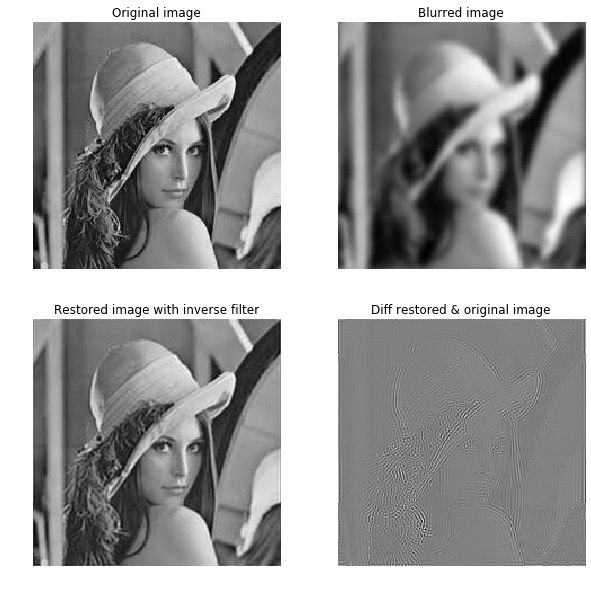

In [4]:
epsilon = 10**-6
freq = fp.fft2(im_blur)
freq_kernel = 1 / (epsilon + freq_kernel) # avoid division by zero
convolved = freq*freq_kernel
im_restored = fp.ifft2(convolved).real
im_restored = 255 * im_restored / np.max(im_restored)

pylab.figure(figsize=(10,10)), pylab.gray()
pylab.subplot(221), pylab.imshow(im)
pylab.title('Original image'), pylab.axis('off')
pylab.subplot(222), pylab.imshow(im_blur)
pylab.title('Blurred image'), pylab.axis('off')
pylab.subplot(223), pylab.imshow(im_restored)
pylab.title('Restored image with inverse filter'), pylab.axis('off')
pylab.subplot(224), pylab.imshow(im_restored - im)
pylab.title('Diff restored & original image'), pylab.axis('off')
pylab.show()

In [14]:
kernel_size = 21                                    # a 21 x 21 motion blurred kernel
mblur_kernel = np.zeros((kernel_size, kernel_size))
mblur_kernel[int((kernel_size-1)/2), :] = np.ones(kernel_size)
mblur_kernel = mblur_kernel / kernel_size

# freq = fp.fft2(mblur_kernel)
# mag1 = (20*np.log10( 0.1 + freq)).astype(int)

# pylab.imshow(mag1), pylab.colorbar()
# pylab.show()


Wiener 필터를 사용한 영상 디컨볼루션

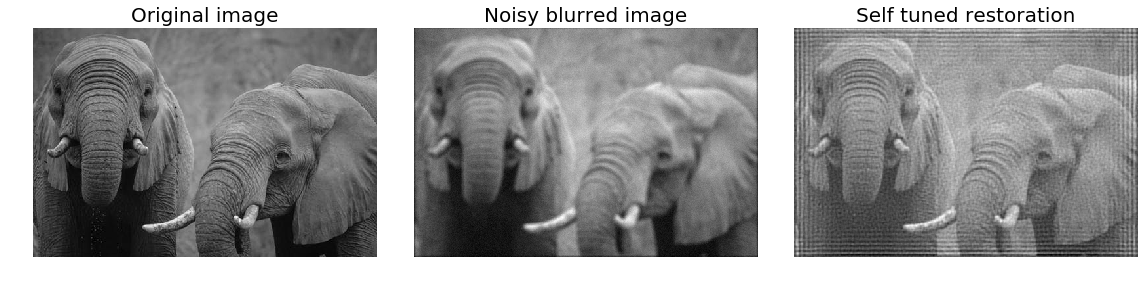

In [17]:
from skimage import color, data, restoration
from scipy.signal import convolve2d as conv2

im = color.rgb2gray(imread('../images/elephant_g.jpg'))
n = 7
psf = np.ones((n, n)) / n**2
im1 = conv2(im, psf, 'same')
im1 += 0.1 * im1.std() * np.random.standard_normal(im1.shape)
im2, _ = restoration.unsupervised_wiener(im1, psf)

fig, axs = pylab.subplots(1, 3, figsize=(16, 4))
axs[0].imshow(im), axs[0].axis('off')
axs[0].set_title('Original image', size=20)
axs[1].imshow(im1), axs[1].axis('off')
axs[1].set_title('Noisy blurred image', size=20)
axs[2].imshow(im2), axs[2].axis('off')
axs[2].set_title('Self tuned restoration', size=20)
pylab.tight_layout(), pylab.gray()   # 명암도 영상으로 표시
pylab.show()

In [ ]:
FFT를 이용한 영상 잡음제거

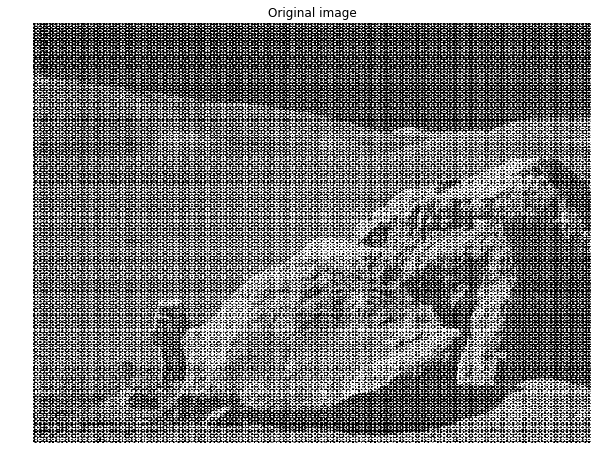

In [4]:
im = pylab.imread('../images/moonlanding.png').astype(float)

pylab.figure(figsize=(10,10))
pylab.imshow(im, pylab.cm.gray), pylab.axis('off'), pylab.title('Original image')
pylab.show()

In [ ]:
잡음 영상의 주파수 스펙트럼

<Figure size 432x288 with 0 Axes>

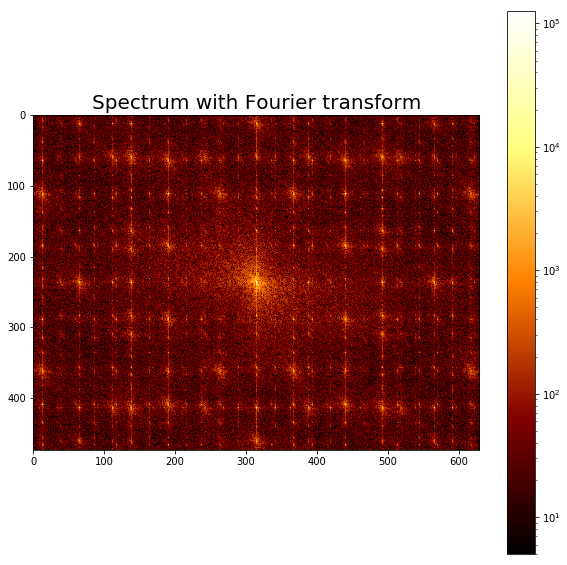

In [21]:
from scipy import fftpack
from matplotlib.colors import LogNorm
im_fft = fftpack.fft2(im)

def plot_spectrum(im_fft):
    pylab.figure(figsize=(10,10))
    pylab.imshow(np.abs(im_fft), norm=LogNorm(vmin=5), cmap='afmhot')
    pylab.colorbar()
    
pylab.figure(), plot_spectrum(fftpack.fftshift(im_fft))
pylab.title('Spectrum with Fourier transform', size=20)
pylab.show()

In [ ]:
FFT 에서 필터링

<Figure size 432x288 with 0 Axes>

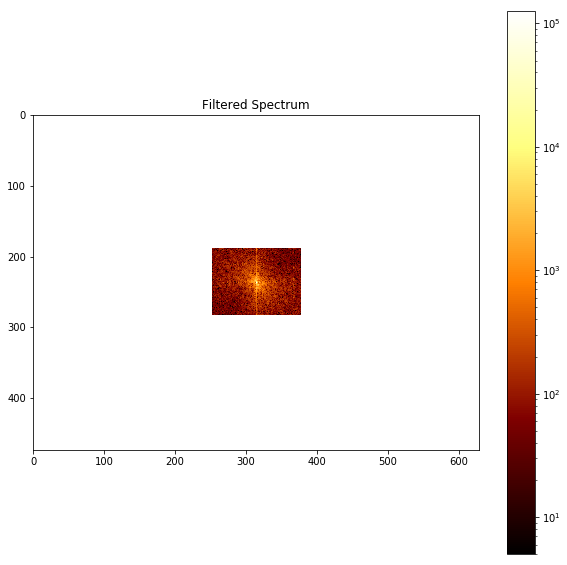

In [14]:
keep_fraction = 0.1							# 남길 계수의 비율 정의
im_fft2 = im_fft.copy()    					# 원본 스펙트럼 복제
r, c = im_fft2.shape						# r, c 는 배열의 행, 열의 수

im_fft2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0		# 행방향 계수 제거
im_fft2[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0	# 열방향 계수 제거

pylab.figure(), plot_spectrum(fftpack.fftshift(im_fft2))
pylab.title('Filtered Spectrum')
pylab.show()

In [ ]:
최종 영상 재구성

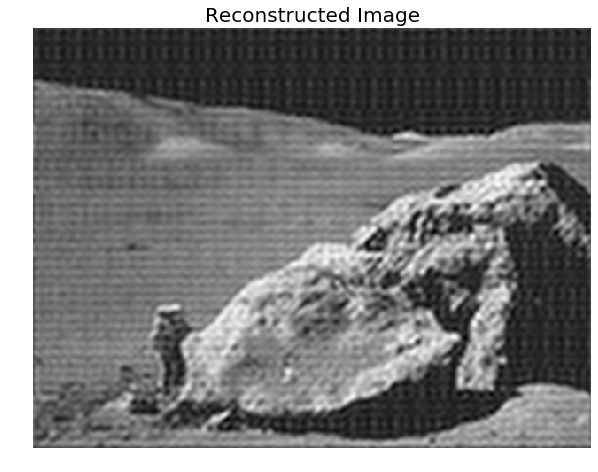

In [47]:
# Reconstruct the denoised image from the filtered spectrum, keep only the real part for display.
im_new = fp.ifft2(im_fft2).real
pylab.figure(figsize=(10,10)), pylab.imshow(im_new, pylab.cm.gray),
pylab.axis('off'), pylab.title('Reconstructed Image', size=20)
pylab.show()